In [4]:
# Import necessary packages
import pandas as pd

In [5]:
# Load dataset
df = pd.read_csv('job_opportunities.csv', encoding='ISO-8859-1')

## Cleaning

#### Pre-cleaning

In [6]:
df.rename(columns={'Requirment of the company ': 'Requirment of the company'}, inplace=True)

# Drop last row
df.drop(df.loc[df['Company'].isnull()].index, axis='rows', inplace=True)

# Drop duplicated rows
df.drop_duplicates(inplace=True)

In [7]:
df['Job Title'] = df['Job Title'].apply(lambda x: str.lower(str.strip(x)))
df['Location'] = df['Location'].apply(lambda x: str.lower(str.strip(x)))

#### Salary

In [8]:
# Save null salary in another dataframe
df_salary_isnull = df.loc[df['Salary'].isnull()]

# Delete those null salary from the main dataframe
df.drop(df_salary_isnull.index, inplace=True)

# Create new column that contains stars True or False
df['Salary_has_star'] = df['Salary'].str.contains('\*')

# Take +, *, and K from salary 
df['Salary'] = df['Salary'].apply(lambda x: str.replace(x, '+', ''))
df['Salary'] = df['Salary'].apply(lambda x: str.replace(x, '*', ''))
df['Salary'] = df['Salary'].apply(lambda x: str.replace(x, 'K', ''))
df['Salary'] = df['Salary'].apply(lambda x: str.strip(x))

In [9]:
# Function is_number
def is_number(number):
    try:
        number = float(number)
        return isinstance(number, float)
    except:
        return False
    
# Function take_currency
import re
def take_currency(salary):
    salary = re.sub(r'[0-9+]', '', salary)
    return str.strip(salary)

# Function remove_currency
def remove_currency(salary):
    salary = re.sub(r'[^0-9]', '', salary)
    return salary

In [10]:
# Create new column that contain the currency
df['Currency'] = df['Salary'].apply(lambda x: 'USD' if is_number(x) else take_currency(x))

# Remove currency from salary
df['Salary'] = df['Salary'].apply(lambda x: remove_currency(x))

# Change salary type to float and multiply to 1000
df['Salary'] = df['Salary'].astype(float) * 1000

df.reset_index(drop=True, inplace=True)

In [11]:
# Normalize salary
from currency_converter import CurrencyConverter

converter = CurrencyConverter()

for i in range(len(df)):
    currency = df['Currency'][i]

    if currency != 'USD':
        df['Salary'][i] = converter.convert(df['Salary'][i], currency, "USD")

/tmp/ipykernel_31998/69151303.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Salary'][i] = converter.convert(df['Salary'][i], currency, "USD")


In [12]:
# Drop the currency column after transforming the salary
df.drop('Currency', axis='columns', inplace=True)

#### Location

In [13]:
df['Location'] = df['Location'].apply(lambda x: str.lower(str.strip(x)))

In [14]:
# # Import Geotext
# from geotext import GeoText

# # Create country column
# df['Country'] = df['Location'].apply(lambda x: GeoText(x).countries[0] if len(GeoText(x).countries) > 0 else None)

#### Requirement and facilities

In [15]:
# Change those to list
df['Requirment of the company'] = df['Requirment of the company'].apply(lambda x: str.split(x, ','))
df['Facilities'] = df['Facilities'].apply(lambda x: str.split(x, ','))

In [16]:
# Create function to delete all empty strings
def delete_empty_in_list(listname):
    while '' in listname:
        listname.remove('')
    return listname

In [17]:
# Remove empty strings on the lists
df['Requirment of the company'] = df['Requirment of the company'].apply(lambda x: delete_empty_in_list(x))
df['Facilities'] = df['Facilities'].apply(lambda x: delete_empty_in_list(x))

In [18]:
# Handle empty facilities
df['Facilities'] = df['Facilities'].apply(lambda x: ['No facilities'] if len(x) == 0 else x)

#### Experience level

In [19]:
# Handle experience level null values
df['Experience level'] = df['Experience level'].apply(lambda x: 'Not specified' if pd.isnull(x) else x)

#### Job category

In [20]:
# Create keywords for jobs
data_science_keywords = [
    'scientist', 'science', 'data analysis', 'data analyst', 'data mining', 'predictive modeling',
    'machine learning', 'statistical analysis', 'data visualization',
    'exploratory data analysis', 'data cleaning', 'feature engineering',
    'regression analysis', 'classification', 'clustering',
    'natural language processing', 'time series analysis', 'data product manager', 'research analyst', 'data analytics',
    'data quality', 'bi', 'business intelligence', 'data management', 'data project management', 'digital analytics',
    'data modeler', 'data product owner', 'cloud database analyst', 'data manager', 'data strategy', 'data specialist',
    'analytics engineer', 'master data', 'data operations', 'data operator', 'dataops', 'data strategist', 'data systems',
    'data reporter', 'data and control systems', 'data developer', 'data analyse', 'data visualisation', 'analyst',
    'data strategies', 'head of data', 'ml'
]

big_data_keywords = [
    'big', 'big data', 'data engineer', 'data enginner','hadoop', 'apache spark', 'spark', 'nosql', 'mapreduce',
    'distributed computing', 'data storage and retrieval', 'data scalability', 'etl',
    'data volume', 'data velocity', 'data variety', 'data processing',
    'data architecture', 'data streaming', 'data lakes', 'streaming data pipelines', 'data architect', 'data storage',
    'data pipeline', 'data platform', 'dataset', 'databricks', 'data integrations', 'data infrastructure', 'data integration',
    'database engineer', 'data lake', 'data modeller', 'data production', 'cloud data', 'data modelling', 'data modeling',
    'database tools'
]

ai_keywords = [
    'artificial intelligence', 'ai', 'machine learning', 'deep learning',
    'neural networks', 'natural language processing', 'computer vision',
    'reinforcement learning', 'robotics', 'expert systems',
    'cognitive computing', 'ai algorithms', 'sentiment analysis',
    'speech recognition', 'image recognition', 'autonomous systems', 'ml',
    'autonomous', 'autonomy', 'robotic', 'vision', 'text analytics', 'chatbot', 'nlp', 'model inference'
]

In [21]:
# Function to classify job titles into DS, AI or Big Data
def classify_job(title):
    str.lower(title)
    categories = []
    if any(keyword in title for keyword in ai_keywords):
        categories.append('Artificial Intelligence')
    if any(keyword in title for keyword in data_science_keywords):
        categories.append('Data Science')
    if any(keyword in title for keyword in big_data_keywords):
        categories.append('Big Data')
    if not categories :
        categories.append('Other')
    return categories

In [22]:
# Create Job Category column
df['Job Category'] = df['Job Title'].apply(lambda x: classify_job(x.lower()))

## Stockage

In [23]:
# Import necessary packages
from sqlalchemy import create_engine, text, Integer, String, Float, Boolean, Date, Column, inspect, UniqueConstraint, ForeignKey, func, desc, select, distinct
from sqlalchemy.orm import create_session, declarative_base, Relationship, sessionmaker

username = 'SA'
password = 'YourPassword123'
hostname = 'localhost'
database = 'Job_opportunities'
driver = 'ODBC+Driver+18+for+SQL+Server'

connection_string = f'mssql+pyodbc://{username}:{password}@{hostname}/{database}?driver={driver}&Encrypt=No'

# Create sqlalchemy engine
engine = create_engine(connection_string)

In [24]:
# Create tables

# Create a base
Base = declarative_base()

# locations
class Locations(Base):
    __tablename__ = 'locations'

    # Columns
    id = Column(Integer, primary_key=True, autoincrement=True)
    location = Column(String(255), nullable=False)

    # Constraints
    __table_args__ = (UniqueConstraint(location, name='locations_location_UQ'),)

# facilities
class Facilities(Base):
    __tablename__ = 'facilities'

    # Columns
    id = Column(Integer, primary_key=True, autoincrement=True)
    facility = Column(String(255), nullable=False)

    # Constraints
    __table_args__ = (UniqueConstraint(facility, name='facilities_facility_UQ'),)

# job_types
class JobTypes(Base):
    __tablename__ = 'job_types'

    # Columns
    id = Column(Integer, primary_key=True, autoincrement=True)
    type = Column(String(50), nullable=False)

    # Constraints
    __table_args__ = (UniqueConstraint(type, name='job_types_type_UQ'),)

# experience_levels
class ExperienceLevels(Base):
    __tablename__ = 'experience_levels'
    
    # Columns
    id = Column(Integer, primary_key=True, autoincrement=True)
    level = Column(String(50), nullable=False)

    # Constraints
    __table_args__ = (UniqueConstraint(level, name='experience_levels_level_UQ'),)

# requirements
class Requirements(Base):
    __tablename__ = 'requirements'

    # Columns
    id = Column(Integer, primary_key=True, autoincrement=True)
    requirement = Column(String(255), nullable=False)

    # Constraints
    __table_args__ = (UniqueConstraint(requirement, name='requirements_requirement_UQ'),)

# jobs
class Jobs(Base):
    __tablename__ = 'jobs'

    # Columns
    id = Column(Integer, primary_key=True, autoincrement=True)
    title = Column(String(255), nullable=False)
    salary = Column(Float, nullable=False)
    salary_has_star = Column(Boolean, nullable=False)
    job_type_id = Column(Integer, ForeignKey('job_types.id'))
    location_id = Column(Integer, ForeignKey('locations.id'))
    experience_level_id = Column(Integer, ForeignKey('experience_levels.id'))

    # UniqueConstraint
    __table_args__ = (UniqueConstraint(
        title, 
        salary, 
        salary_has_star, 
        job_type_id,
        location_id,
        experience_level_id,
        name='jobs_UQ'
    ),)

    # Relationships
    job_types_jobs = Relationship('JobTypes', backref='jobs')
    locations_jobs = Relationship('Locations', backref='jobs')
    experience_levels_jobs = Relationship('ExperienceLevels', backref='jobs')

# job_facilities
class JobFacilities(Base):
    __tablename__ = 'job_facilities'

    # Columns
    id = Column(Integer, primary_key=True, autoincrement=True)
    job_id = Column(Integer, ForeignKey('jobs.id'))
    facility_id = Column(Integer, ForeignKey('facilities.id'))

    # Unique constraints
    __table_args__ = (UniqueConstraint(job_id, facility_id, name='job_facility_UQ'),)

    # Relationships
    job_jf = Relationship('Jobs', backref='job_facilities')
    facility_fj = Relationship('Facilities', backref='job_facilities')

# job_requirements
class JobRequirements(Base):
    __tablename__ = 'job_requirements'

    # Columns
    id = Column(Integer, primary_key=True, autoincrement=True)
    requirement_id = Column(Integer, ForeignKey('requirements.id'))
    job_id = Column(Integer, ForeignKey('jobs.id'))

    # Unique constraints
    __table_args__ = (UniqueConstraint(requirement_id, job_id, name='job_requirements_UQ'),)

    # Relationships
    requirement_jr = Relationship('Requirements', backref='job_requirements')
    job_jr = Relationship('Jobs', backref='job_requirements')


# Categories
class Categories(Base):
    __tablename__ = 'categories'

    # Columns
    id = Column(Integer, primary_key=True, autoincrement=True)
    category = Column(String(255), nullable=False)

    # UniqueConstraints
    __table_args__ = (UniqueConstraint(category, name='categories_category_UQ'),)

# Job_categories
class JobCategories(Base):
    __tablename__ = 'job_categories'

    # Column
    id = Column(Integer, primary_key=True, autoincrement=True)
    category_id = Column(Integer, ForeignKey('categories.id'))
    job_id = Column(Integer, ForeignKey('jobs.id'))

    # Unique constraints
    __table_args__ = (UniqueConstraint(category_id, job_id, name='job_categories_UQ'),)

    # Relationships
    category_jc = Relationship('Categories', backref='job_categories')
    job_jc = Relationship('Jobs', backref='job_categories')

try:
    Base.metadata.create_all(engine)
    print('Tables created successfully')
except Exception as ex:
    print(ex)

Tables created successfully


In [25]:
inspector = inspect(engine)

inspector.get_table_names()

['categories',
 'experience_levels',
 'facilities',
 'job_categories',
 'job_facilities',
 'job_requirements',
 'job_types',
 'jobs',
 'locations',
 'requirements']

In [26]:
# Create session
session = create_session(engine)

In [27]:
# with engine.connect() as conn:
    # conn.execute(text('drop table job_requirements'))
    # conn.execute(text('drop table job_facilities'))
    # conn.execute(text('drop table job_categories'))
    # conn.execute(text('drop table jobs'))
    # conn.execute(text('drop table job_types'))
    # conn.execute(text('drop table locations'))
    # conn.execute(text('drop table categories'))
    # conn.execute(text('drop table experience_levels'))
    # conn.execute(text('drop table facilities'))
    # conn.execute(text('drop table requirements'))
    # conn.commit()

### Insertion des données dans la base

In [28]:
# # Tables that don't have foregin keys
# try:
#     # Locations
#     for location in df['Location'].unique():
#         new_location = Locations(location=str(location))
#         session.add(new_location)

#     # Facilities
#     for facility in df['Facilities'].explode().unique():
#         new_facility = Facilities(facility=str(facility))
#         session.add(new_facility)

#     # Categories
#     for category in df['Job Category'].explode().unique():
#         new_category = Categories(category=str(category))
#         session.add(new_category)

#     # Requirements
#     for requirement in df['Requirment of the company'].explode().unique():
#         new_requirement = Requirements(requirement=str(requirement))
#         session.add(new_requirement)

#     # Experience levels
#     for experience_level in df['Experience level'].unique():
#         new_experience_level = ExperienceLevels(level=str(experience_level))
#         session.add(new_experience_level)

#     # Job types
#     for job_type in df['Job Type'].unique():
#         new_job_type = JobTypes(type=str(job_type))
#         session.add(new_job_type)

#     session.commit()
#     print('All rows inserted successfully')
# except Exception as e:
#     session.rollback()
#     print('Error', e)
#     print('No row inserted')
# finally:
#     session.close()

In [29]:
# Check if the insertion went good
df['Facilities'].explode().unique().shape[0] == session.query(Facilities).count()

True

In [30]:
job_columns = [
    'Job Title', 
    'Salary', 
    'Salary_has_star', 
    'Job Type', 
    'Location',
    'Experience level'
]
jobs_df = df[job_columns]
jobs_df.drop_duplicates(inplace=True)
jobs_df.reset_index(inplace=True, drop=True)

/tmp/ipykernel_31998/2361147866.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  jobs_df.drop_duplicates(inplace=True)


In [31]:
# # Create session
# session = create_session(engine)

# # insert into jobs
# with session.begin():
#     try:
#         for i in range(len(jobs_df)):
#             title = jobs_df['Job Title'][i]
#             salary = float(jobs_df['Salary'][i])
#             salary_has_star = bool(jobs_df['Salary_has_star'][i])
#             job_type = jobs_df['Job Type'][i]
#             job_type_id = session.query(JobTypes).filter(JobTypes.type==job_type).first().id
#             location = jobs_df['Location'][i]
#             location_id = session.query(Locations).filter_by(location=location).first().id
#             experience_level = jobs_df['Experience level'][i]
#             experience_level_id = session.query(ExperienceLevels).filter_by(level=experience_level).first().id

#             # new jobs
#             new_job = Jobs(
#                 title=title,
#                 salary=salary,
#                 salary_has_star=salary_has_star,
#                 job_type_id=job_type_id,
#                 location_id=location_id,
#                 experience_level_id=experience_level_id
#             )
#             session.add(new_job)

#         # Commit the transaction
#         session.commit()
#         print('All rows inserted successfully')
#     except Exception as e:
#         # Roll back the transaction
#         session.rollback()
#         print('Error ',e)
#         print('No row inserted')
# session.close()

In [32]:
# Check if the insertion went good
jobs_df.shape[0] == session.query(Jobs).count()

True

In [33]:
# Job facilities df
job_facilities_columns = job_columns + ['Facilities']
job_facilities_df = df[job_facilities_columns].explode('Facilities', ignore_index=True)
job_facilities_df['Facilities'] = job_facilities_df['Facilities'].apply(lambda x: str.lower(str.strip(x)))
job_facilities_df.drop_duplicates(inplace=True)
job_facilities_df.reset_index(inplace=True, drop=True)

In [34]:
# # Insert into job facilities 

# print(f"{job_facilities_df.shape[0]} rows to insert\n")

# # Create a session
# Session = sessionmaker(bind=engine)
# session = Session()

# for i in range(len(job_facilities_df)):
#     with session.begin():
#         try:
#             # Get job id
#             title = job_facilities_df['Job Title'][i]
#             salary = job_facilities_df['Salary'][i]
#             salary_has_star = job_facilities_df['Salary_has_star'][i]
#             job_type = job_facilities_df['Job Type'][i]
#             job_type_id = session.query(JobTypes).filter_by(type=job_type).first().id
#             location = job_facilities_df['Location'][i]
#             location_id = session.query(Locations).filter_by(location=location).first().id
#             experience_level = job_facilities_df['Experience level'][i]
#             experience_level_id = session.query(ExperienceLevels).filter_by(level=experience_level).first().id
#             job_id = session.query(Jobs).filter_by(
#                 title=title,
#                 salary=salary,
#                 salary_has_star=salary_has_star,
#                 job_type_id=job_type_id,
#                 location_id=location_id,
#                 experience_level_id=experience_level_id
#             ).first().id

#             # Get facility id
#             facility = job_facilities_df['Facilities'][i]
#             facility_id = session.query(Facilities).filter_by(facility=facility).first().id

#             # New row 
#             new_row_job_facility = JobFacilities(job_id=job_id, facility_id=facility_id)
#             session.add(new_row_job_facility)

#             # Commit the transaction
#             session.commit()
#             print(f"Row {i} inserted successfully", end='\r')
#         except Exception as e:
#             # Roll back the transaction
#             session.rollback()
#             print(f"Row {i} has a problem")
#             print(e)
#             break

In [35]:
# Check if the insertion went good
job_facilities_df.shape[0] == session.query(JobFacilities).count()

True

In [36]:
# Job categories df
job_categories_columns = job_columns + ['Job Category']
job_categories_df = df[job_categories_columns].explode('Job Category', ignore_index=True)
job_categories_df['Job Category'] = job_categories_df['Job Category'].apply(lambda x: str.lower(str.strip(x)))
job_categories_df.drop_duplicates(inplace=True)
job_categories_df.reset_index(inplace=True, drop=True)

In [37]:
# # Insert into job Categories
# print(f"{job_categories_df.shape[0]} rows to insert\n")

# # Create a session
# Session = sessionmaker(bind=engine)
# session = Session()

# for i in range(129, len(job_categories_df)):
#     with session.begin():
#         try:
#             # Get category id 
#             category = job_categories_df['Job Category'][i]
#             category_id = session.query(Categories).filter_by(category=category).first().id

#             # Get job id
#             title = job_categories_df['Job Title'][i]
#             salary = job_categories_df['Salary'][i]
#             salary_has_star = job_categories_df['Salary_has_star'][i]
#             job_type = job_categories_df['Job Type'][i]
#             job_type_id = session.query(JobTypes).filter_by(type=job_type).first().id
#             location = job_categories_df['Location'][i]
#             location_id = session.query(Locations).filter_by(location=location).first().id
#             experience_level = job_categories_df['Experience level'][i]
#             experience_level_id = session.query(ExperienceLevels).filter_by(level=experience_level).first().id
#             job_id = session.query(Jobs).filter_by(
#                 title=title,
#                 salary=salary,
#                 salary_has_star=salary_has_star,
#                 job_type_id=job_type_id,
#                 location_id=location_id,
#                 experience_level_id=experience_level_id
#             ).first().id

#             # New row 
#             new_row_job_category = JobCategories(job_id=job_id, category_id=category_id)
#             session.add(new_row_job_category)

#             # Commit the transaction
#             session.commit()
#             print(f"Row {i} inserted successfully", end='\r')
#         except Exception as e:
#             # Roll back the transaction
#             session.rollback()
#             print(f"Row {i} has a problem")
#             print(e)
#             break

In [38]:
# Check if the insertion went good
job_categories_df.shape[0] == session.query(JobCategories).count()

True

In [39]:
# Job requirements df
job_requirements_columns = job_columns + ['Requirment of the company']
job_requirements_df = df[job_requirements_columns].explode('Requirment of the company', ignore_index=True)
job_requirements_df['Requirment of the company'] = job_requirements_df['Requirment of the company'].apply(lambda x: str.lower(str.strip(x)))
job_requirements_df.drop_duplicates(inplace=True)
job_requirements_df.reset_index(inplace=True, drop=True)

In [40]:
# # Insert into job requirements
# print(f"{job_requirements_df.shape[0]} rows to insert\n")

# # Create a session
# Session = sessionmaker(bind=engine)
# session = Session()

# for i in range(len(job_requirements_df)):
#     with session.begin():
#         try:
#             # Get requirement id 
#             requirement = job_requirements_df['Requirment of the company'][i]
#             requirement_id = session.query(Requirements).filter_by(requirement=requirement).first().id

#             # Get job id
#             title = job_requirements_df['Job Title'][i]
#             salary = job_requirements_df['Salary'][i]
#             salary_has_star = job_requirements_df['Salary_has_star'][i]
#             job_type = job_requirements_df['Job Type'][i]
#             job_type_id = session.query(JobTypes).filter_by(type=job_type).first().id
#             location = job_requirements_df['Location'][i]
#             location_id = session.query(Locations).filter_by(location=location).first().id
#             experience_level = job_requirements_df['Experience level'][i]
#             experience_level_id = session.query(ExperienceLevels).filter_by(level=experience_level).first().id
#             job_id = session.query(Jobs).filter_by(
#                 title=title,
#                 salary=salary,
#                 salary_has_star=salary_has_star,
#                 job_type_id=job_type_id,
#                 location_id=location_id,
#                 experience_level_id=experience_level_id
#             ).first().id

#             # New row 
#             new_row_job_requirement = JobRequirements(job_id=job_id, requirement_id=requirement_id)
#             session.add(new_row_job_requirement)

#             # Commit the transaction
#             session.commit()
#             print(f"Row {i} inserted successfully", end='\r')
#         except Exception as e:
#             # Roll back the transaction
#             session.rollback()
#             print(f"Row {i} has a problem")
#             print(e)
#             break

In [41]:
# Check if the insertion went good
job_requirements_df.shape[0] == session.query(JobRequirements).count()

True

### Analyse et visualisation

#### Quel est le marché le plus demandé ?

In [42]:
result = session.query(Categories.category, func.count(JobCategories.job_id)).\
    join(Categories).\
    group_by(Categories.category).\
    order_by(desc(func.count(JobCategories.job_id))).\
    all()

most_demanded_job = {x[0]: x[1] for x in result}

most_demanded_job

{'Data Science': 1933,
 'Big Data': 684,
 'Artificial Intelligence': 632,
 'Other': 58}

In [43]:
# Plot the market tendance
from bokeh.plotting import figure, show
from bokeh.io import output_notebook

output_notebook()

jobs_categories = list(most_demanded_job.keys())
job_counts = list(most_demanded_job.values())

most_demanded_job_plot = figure(width=400, height=400, x_range=jobs_categories)
most_demanded_job_plot.vbar(x=jobs_categories, top=job_counts, width=0.5, bottom=0, color='darkblue')

# Labels
most_demanded_job_plot.xaxis.axis_label = 'Job Categories'
most_demanded_job_plot.yaxis.axis_label = 'Nombre d\'apparition'
most_demanded_job_plot.title.text = 'Le marché les plus demandés'

show(most_demanded_job_plot)

Loading BokehJS ...

### Compétences les plus demandés

In [44]:
# requirement_count_procedure_query = text('''
# CREATE FUNCTION GetRequirementsCountByCategory (@categoryName VARCHAR(255))
# RETURNS TABLE
# AS
# RETURN (
#     SELECT r.requirement, COUNT(jr.job_id) AS job_count
#     FROM requirements r
#     JOIN job_requirements jr ON jr.requirement_id = r.id
#     JOIN jobs j ON j.id = jr.job_id
#     JOIN job_categories jc ON j.id = jc.job_id
#     JOIN categories c ON c.id = jc.category_id
#     WHERE c.category = @categoryName
#     GROUP BY r.requirement
# );                                
# ''')
# with engine.connect() as conn:
#     conn.execute(requirement_count_procedure_query)
#     conn.commit()

In [45]:
# Function to het the most demanded skills
def get_requirements_count_by_category(category_name):
    query = text(f"SELECT * FROM GetRequirementsCountByCategory(:categoryName) ORDER BY job_count DESC")
    result = session.execute(query, {'categoryName': category_name})
    # Create dict containing results
    most_demand_skills = {x[0]: x[1] for x in result.fetchall()}
    # Transform dict to dataframe
    most_demand_skills_df = pd.DataFrame(data=list(most_demand_skills.items()), columns=['Skill', 'Job Count'])
    return most_demand_skills_df

#### Data Science 

In [46]:
# Retrieve requirements from database and their counts where category is Data Science
data_science_skills = get_requirements_count_by_category('data science')
data_science_skills.head()

,Skill,Job Count
0,Computer Science,687
1,Engineering,668
2,Data analysis,425
3,AWS,402
4,Machine Learning,359


In [47]:
# Import plotly express
import plotly.express as px

number_of_line = 20
skills = data_science_skills.head(number_of_line)['Skill']
jobs_counts = data_science_skills.head(number_of_line)['Job Count']

# Create the bar chart
skills_fig = px.bar(
    x=skills, 
    y=jobs_counts, 
    labels={'x': 'Compétences', 'y': 'Nombre de demandes'}, title='Compétences les plus demandés en Data Science',
    color=data_science_skills.head(number_of_line)['Job Count']
)


# Customize the layout
skills_fig.update_layout(
    title_font=dict(size=24),
    xaxis=dict(title_font=dict(size=16)),
    yaxis=dict(title_font=dict(size=16)),
    font=dict(size=14),
    font_color='white',
    plot_bgcolor='#101F6A',
    paper_bgcolor='#17266D',
    xaxis_showgrid=False,
    yaxis_showgrid=True
)

# Show the plot in notebook
skills_fig.show()

#### Big Data

In [48]:
# Retrieve requirements where category is Big DATA
big_data_skills = get_requirements_count_by_category('Big data')
big_data_skills.head()

,Skill,Job Count
0,AWS,362
1,Architecture,323
2,Azure,254
3,Computer Science,248
4,Big Data,236


In [49]:
# Import plotly express
import plotly.express as px

number_of_line = 20
skills = big_data_skills.head(number_of_line)['Skill']
jobs_counts = big_data_skills.head(number_of_line)['Job Count']

# Create the bar chart
skills_fig = px.bar(
    x=skills, 
    y=jobs_counts, 
    labels={'x': 'Compétences', 'y': 'Nombre de demandes'}, title='Compétences les plus demandés en Big DATA',
)


# Customize the layout
skills_fig.update_layout(
    title_font=dict(size=24),
    xaxis=dict(title_font=dict(size=16)),
    yaxis=dict(title_font=dict(size=16)),
    font=dict(size=14),
    font_color='white',
    plot_bgcolor='#101F6A',
    paper_bgcolor='#17266D',
    xaxis_showgrid=False,
    yaxis_showgrid=False
)

# Show the plot in notebook
skills_fig.show()

#### Artificial Intelligence

In [50]:
ai_skills = get_requirements_count_by_category('artificial intelligence')
ai_skills.head()

,Skill,Job Count
0,Computer Science,309
1,Engineering,297
2,Machine Learning,199
3,Architecture,178
4,AWS,174


In [51]:
# Import plotly express
import plotly.express as px

number_of_line = 20
skills = ai_skills.head(number_of_line)['Skill']
jobs_counts = ai_skills.head(number_of_line)['Job Count']

# Create the bar chart
skills_fig = px.bar(
    x=skills, 
    y=jobs_counts, 
    labels={'x': 'Compétences', 'y': 'Nombre de demandes'}, title='Compétences les plus demandés en Intelligence Artificielle',
    color=jobs_counts,
    color_continuous_scale='Blues'
)


# Customize the layout
skills_fig.update_layout(
    title_font=dict(size=24),
    xaxis=dict(title_font=dict(size=16)),
    yaxis=dict(title_font=dict(size=16)),
    font=dict(size=14),
    font_color='white',
    plot_bgcolor='#101F6A',
    paper_bgcolor='#17266D',
    xaxis_showgrid=False,
    yaxis_showgrid=False
)

# Show the plot in notebook
skills_fig.show()

### Similarité et différences des compétences entre IA, Data Science et Big DATA

In [52]:
result = session.query(Requirements.requirement).\
    join(JobRequirements).\
    join(Jobs).\
    join(JobCategories).\
    join(Categories).\
    filter(Categories.category.in_(['data science', 'artificial intelligence', 'big data'])).\
    group_by(Requirements.requirement).\
    having(func.count(distinct(Categories.id)) == 3).\
    all()
skills_similarity = [x[0] for x in result]

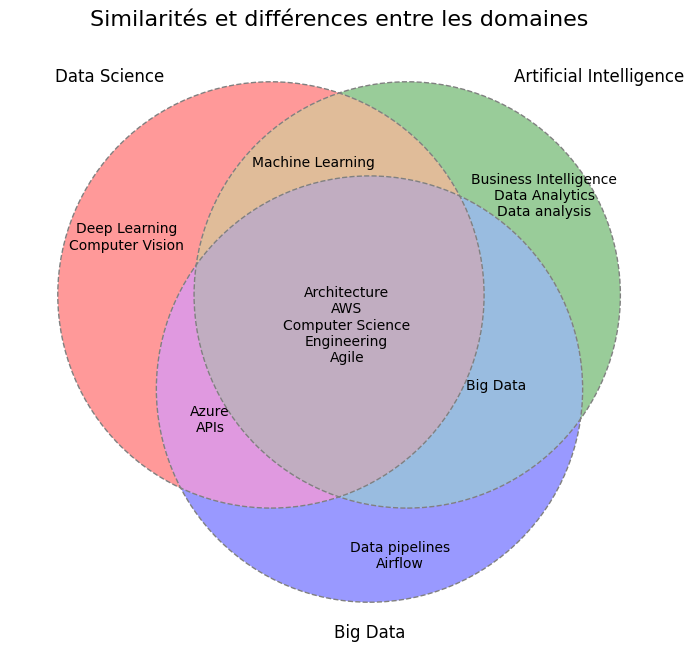

In [53]:
import matplotlib.pyplot as plt
from matplotlib_venn import venn3, venn3_circles
plt.figure(figsize=(10, 8))

# Number of rows
number_of_row = 10

data_science = set(data_science_skills['Skill'].head(number_of_row))
artificial_intelligence = set(ai_skills['Skill'].head(number_of_row))
big_data = set(big_data_skills['Skill'].head(number_of_row))

# Create the Venn diagram
venn = venn3([data_science, artificial_intelligence, big_data], set_labels=('Data Science', 'Artificial Intelligence', 'Big Data'))

# Add custom labels for each set
venn.get_label_by_id('100').set_text('\n'.join(artificial_intelligence - data_science - big_data))
venn.get_label_by_id('010').set_text('\n'.join(data_science - artificial_intelligence - big_data))
venn.get_label_by_id('001').set_text('\n'.join(big_data - artificial_intelligence - data_science))
venn.get_label_by_id('110').set_text('\n'.join(artificial_intelligence & data_science - big_data))
venn.get_label_by_id('101').set_text('\n'.join(artificial_intelligence & big_data - data_science))
venn.get_label_by_id('011').set_text('\n'.join(data_science & big_data - artificial_intelligence))
venn.get_label_by_id('111').set_text('\n'.join(artificial_intelligence & data_science & big_data))

# Customize the Venn diagram
venn_circles = venn3_circles([data_science, artificial_intelligence, big_data], linestyle='dashed', linewidth=1, color='grey')

plt.title('Similarités et différences entre les domaines', fontsize=16)
# Show the Venn diagram
plt.show()


### Les postes les plus courants

In [61]:
result = session.query(Jobs.title, func.count(Jobs.title)).group_by(Jobs.title).order_by(desc(func.count(Jobs.title))).all()
most_job_title = {x[0]: x[1] for x in result}
most_job_title_df = pd.DataFrame(list(most_job_title.items()), columns=['Job Title', 'job_counts'])
most_job_title_df.head(10)

,Job Title,job_counts
0,data engineer,100
1,data scientist,75
2,data analyst,74
3,senior data engineer,57
4,machine learning engineer,46
5,senior data analyst,35
6,senior data scientist,31
7,senior machine learning engineer,21
8,analytics engineer,16
9,data architect,11


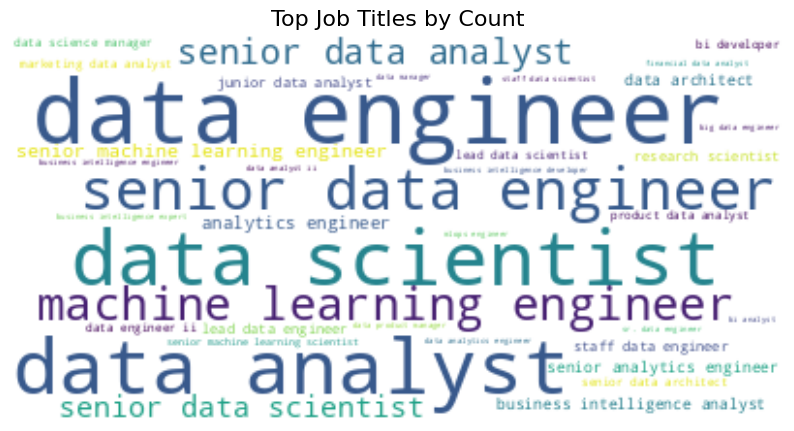

In [65]:
# Create a WordCloud object with custom settings
wordcloud = WordCloud(
    background_color='white',
    colormap='viridis',
    contour_color='steelblue',
    prefer_horizontal=1,  # Horizontal layout of words
    relative_scaling=0.5,  # Adjusts the font size based on counts
).generate_from_frequencies(most_job_title)

# Display the WordCloud using matplotlib
plt.figure(figsize=(10, 6))  # Set the size of the figure (width, height)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Top Job Titles by Count', fontsize=16)

# Show the plot
plt.show()